In [1]:
%env PYTHONWARNINGS=ignore::FutureWarning:xgboost.core
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module=r".*xgboost.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*glibc.*")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

env: PYTHONWARNINGS=ignore::FutureWarning:xgboost.core


In [2]:
data_dir = os.path.join(os.getenv('HOME'), 'modulabs/work/kaggle_kakr_housing/data')

train_data_path = os.path.join(data_dir, 'train.csv')
sub_data_path = os.path.join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

# <span style="color:red"><후기>  
<span style="color:red">
앙상블 모델과 그리드 서치에 대해 특히 잘 알수 있었다.<br>
하지만, 한번 수행하는데 시간이 너무 오래 걸려서 오류를 수정하는데 너무 힘들었다.<br>
한번 오류 나면 버리는 시간이...<br>
아니면 오류는 안나지만 기다리다 기다리다 중단하고 하이퍼 파라메타 수정...<br>
잘 돌다가 워커 죽고...<br>
나중에는 한번 오류 나거나 수정할 때 마다 미칠것 같았다 ㅋㅋㅋ<br>
수정을 위해서 기다리는 시간이 수정하고 코딩하는 시간보다 훨씬! 매우! 더 길었던 것 같다.<br>
<br>
앙상블과 그리드 서치를 모두 사용했지만 순위는 더 떨어졌다.<br>
빠른 코딩을 위해 서치 시간 단축에 맞춰 하이퍼 파라메타를 조정하다보니 최적화에서 멀어진것 같다.

<img src = "./submission.PNG">

# 1. 데이터 확인 및 전처리
  
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [19]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


## 1.1 필요없는 data 삭제
- price -> target
- price, id 삭제
- date: 년,월 만 남겨서 수치화

In [20]:
y = train['price']

del train['price']
del train['id']
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

test_id = test['id']
del test['id']
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

print(train.columns)
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## 1.2 전처리를 위해 데이터 합치기

In [5]:
train_len = len(train) #전처리 후 train, test 데이터 분리를 위한 길이 기억
data = pd.concat((train, test), axis=0) #전처리를 위해 데이터 합치기
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 1.2.1 결측치 확인

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


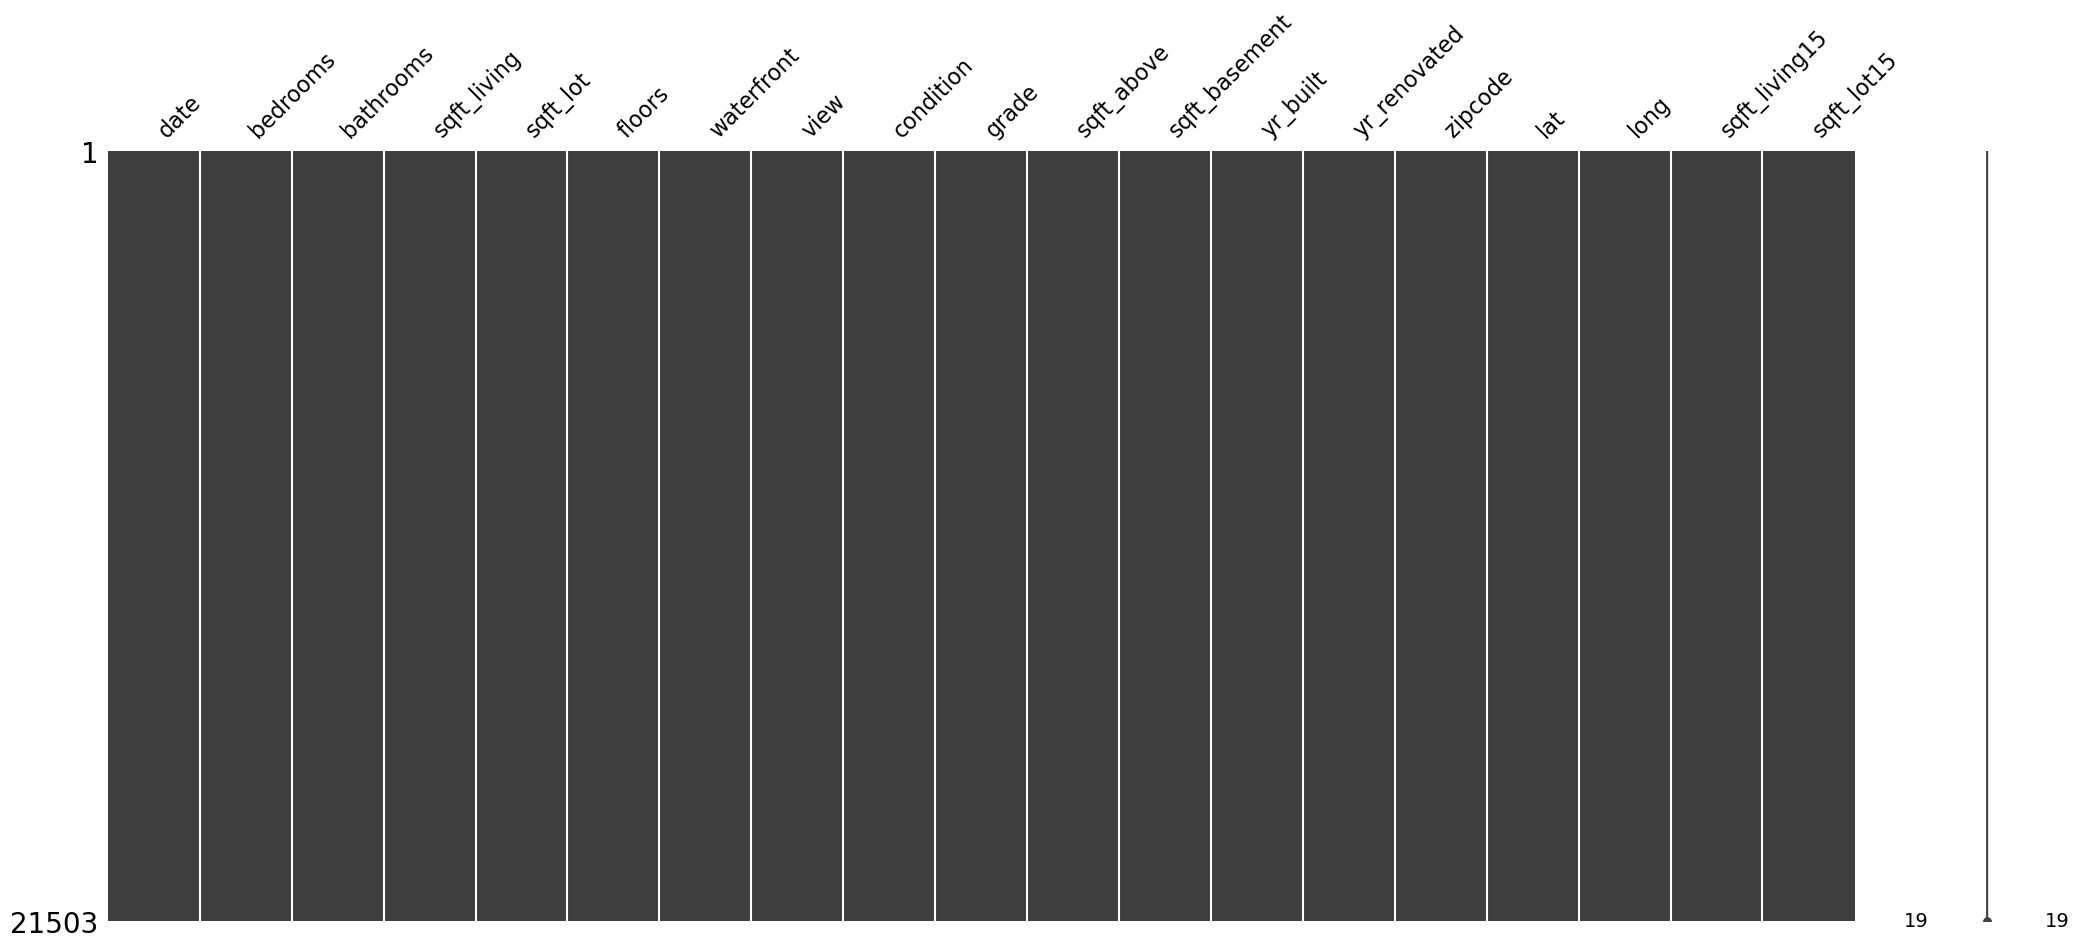

In [6]:
# missingno 라이브러리의 matrix 함수를 사용하여,  
# 데이터의 결측 상태를 시각화를 통해 확인
msno.matrix(data)

# 수치화를 통해 결측치 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

### 1.2.2 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로  
log scaling으로 정규 분포에 비슷하게 만들어 준다.

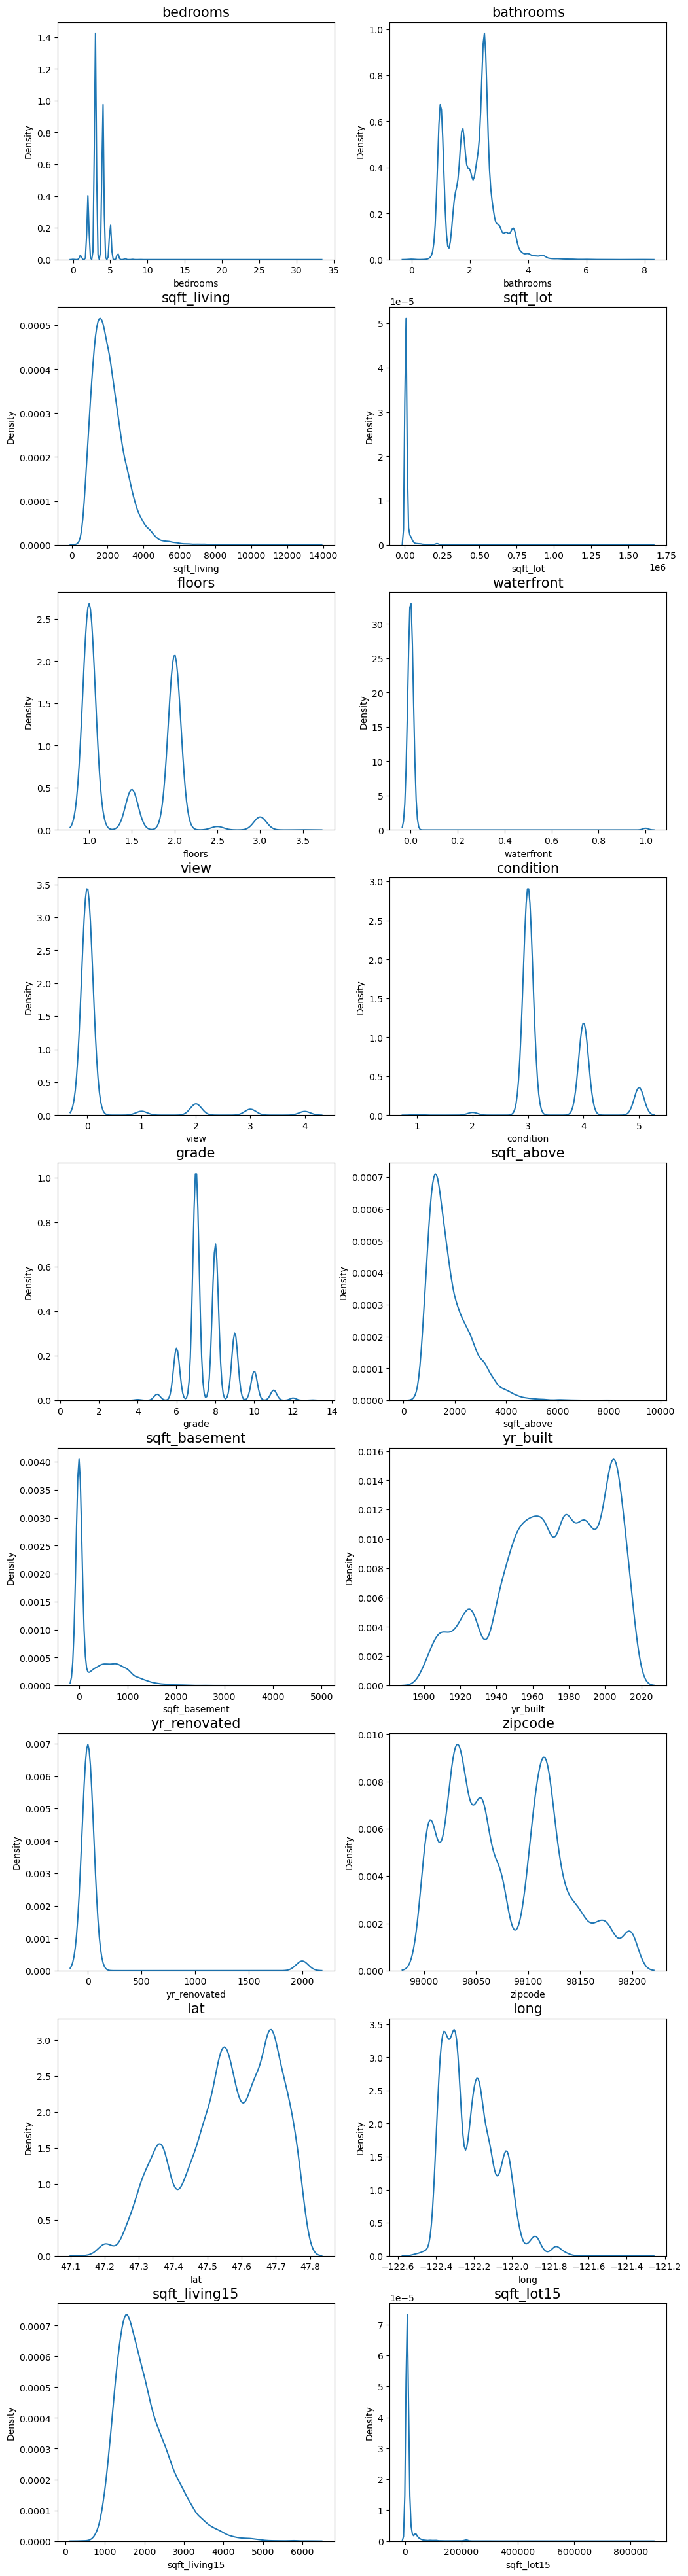

In [7]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

count = 1 # id 변수(count==0인 경우)는 제외하고 분포를 확인 (날짜 데이터 분포)
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

### 1.2.3 많이 치우친 데이터
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만든다.

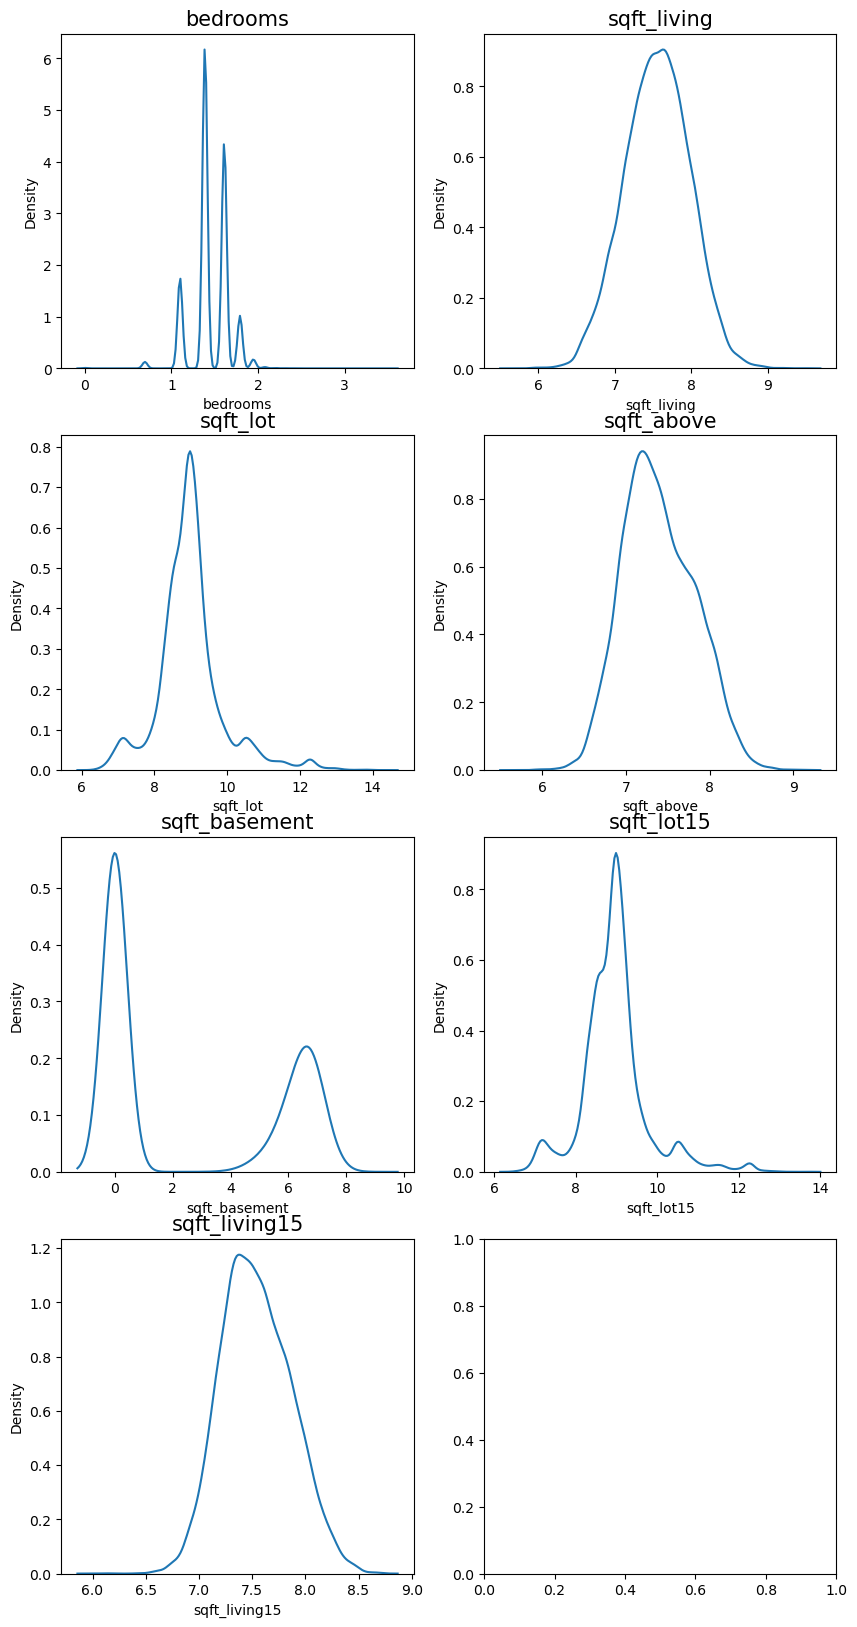

In [8]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

# 가공된 데이터 확인
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
count = 0
for row in range(4):
    for col in range(2):
        if count == len(skew_columns):
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

### 1.2.4 taget 데이터 분포 확인 및 가공
target data 도 한쪽으로 치우침이 심한것을 확인했으므로
log scale 적용을 통해 정규분포에 가까워짐을 확인했다.

단! target data는 input data와는 달리 log scale 적용값을 저장하지 않는다.
이유는, 나중에 결과를 다시 inverse 해서 원래 scale로 돌려야 하는데,
일일이 그렇게 하는것 보다 나중에 모델에 TransformedTargetRegressor을 사용하면,
신경쓰지 않고 자동으로 처리할 수 있기 때문

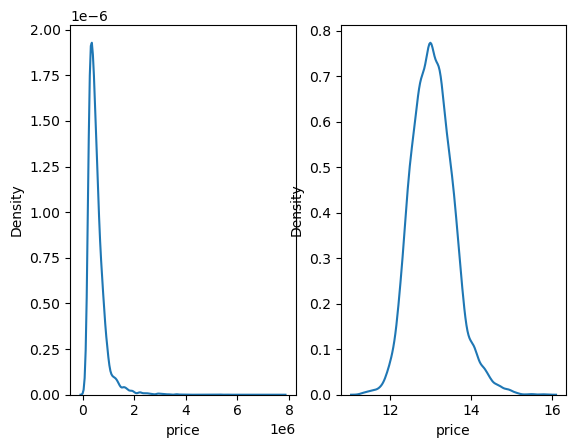

In [9]:
plt.subplot(1,2,1)
sns.kdeplot(y)

plt.subplot(1,2,2)
y_log = np.log1p(y)
sns.kdeplot(y_log)

plt.show()

## 1.3 전처리 끝, taget, test 데이터 분리

In [10]:
train = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]
del data

print(train.shape)
print(test.shape)
train.info()

(15035, 19)
(6468, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  f

# <span style="color:red">2. 모델링  


### <span style="color:red">실패기록 1. Ensemble 과 GridSearch 조합
<span style="color:red">Ensemble 모델을 만들고 한방에 GridSearch까지 적용하는 모델을 만들었는데,<br>
조합 수가 어마어마 해져서 한번 연산하는데 시간이 말도 안되게 오래 걸려서 포기함 (중간 중간 확인하는게 불가능)<br>
그래서<br>
개별 모델별로 GridSearch를 적용하고<br>
거기서 나온 파라메타로 모델을 고정하고<br>
그걸로 Ensemble을 다시 만들었다.<br>
<br>
### <span style="color:red">실패기록 2. TransformedTargetRegressor(TTR) 과 하이퍼 파라미터
<span style="color:red">TransformedTargetRegressor(TTR)를 그 자체로 그리드서치하면,<br>
모델의 하이퍼파라미터는 그대로 이름을 쓰면 안 되고 regressor__ 프리픽스를 붙여야 한다.<br>
아니면 error<br>
<br>
### <span style="color:red">실패기록 3. GridSearch 시 RandomForestRegressor 에서 워커 프로세스가 죽는 문제, 너무 오래 걸리는 문제
<span style="color:red">n_jobs=-1 -> n_jobs=4 로 수정<br>
하이퍼 파라메타 계속! 대폭! 수정<br>

## 2.1 학습 데이터 확인

In [11]:
print(train.shape)
print(y.shape)

(15035, 19)
(15035,)


## <span style="color:red">2.2 개별 모델 GridSearch  
### <span style="color:red">2.2.1 모델 기본 세팅 및 TransformedTargetRegressor 적용  
  
<span style="color:red"><사용된 모델><br>
GradientBoostingRegressor<br>
XGBRegressor<br>
LGBMRegressor<br>
RandomForestRegressor<br>
<br>
TransformedTargetRegressor를 적용하면 자동으로<br>
target data를 학습할 때는 log scale을 취하고<br>
학습이 끝난 후<br>
test할 때는 원래 scale로 되돌린 target을 얻을 수 있다.

In [12]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV

#------------------------------
gboost = GradientBoostingRegressor(random_state=2019)
gboost_TTR = TransformedTargetRegressor(regressor=gboost,
                                   func=np.log1p,       # log(1+y)
                                   inverse_func=np.expm1) 
fast_gboost_TTR = {                      # 내장 Early Stop 기능으로 fit 시간 줄이기
    "regressor__n_iter_no_change": 10,     # 10번 연속 개선 없으면 중단
    "regressor__validation_fraction": 0.1, # 10%를 검증으로 사용
    "regressor__tol": 1e-4,                # 개선 판단 임계치
}
gboost_TTR.set_params(**fast_gboost_TTR)

#------------------------------
xgboost = XGBRegressor(random_state=2019, n_jobs=-1, tree_method="hist", objective="reg:squarederror")
xgboost_TTR = TransformedTargetRegressor(regressor=xgboost,
                                   func=np.log1p,       # log(1+y)
                                   inverse_func=np.expm1)

#------------------------------
lightgbm = LGBMRegressor(random_state=2019, n_jobs=-1, verbose=-1)
lightgbm_TTR = TransformedTargetRegressor(regressor=lightgbm,
                                   func=np.log1p,       # log(1+y)
                                   inverse_func=np.expm1)
fast_lightgbm_TTR = {                      # fit 시간 줄이기
    "regressor__max_bin": 127,  # 기본 255 → 127로 절반, 속도↑(약간의 정밀도 손실 가능)
}
lightgbm_TTR.set_params(**fast_lightgbm_TTR)

#------------------------------
rdforest = RandomForestRegressor(
    random_state=2019,
    n_jobs=1,             # ★ 내부 병렬 끄기
    # 메모리/시간 절약 옵션:
    oob_score=False,    # 기본 False
    max_samples=0.7,    # (bootstrap=True일 때 유효) 샘플 부분추출로 속도/메모리↓
)
rdforest_TTR = TransformedTargetRegressor(regressor=rdforest,
                                   func=np.log1p,       # log(1+y)
                                   inverse_func=np.expm1)

### 2.2.2 GridSearch 하이퍼 파라메타 설정

In [13]:
# ====== 공통 세팅 ======
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "neg_root_mean_squared_error"  # (= -RMSE)

# ====== 모델 & 그리드 정의 ======
candidates = {#8.83분
    "GradientBoosting": {
        "estimator": gboost_TTR,
        "param_grid": {
            "regressor__learning_rate":    [0.03, 0.05],        # 2
            "regressor__n_estimators":     [400, 700, 1000],    # 3
            "regressor__max_depth":        [2, 3],              # 2
            "regressor__min_samples_leaf": [1, 5],              # 2
            "regressor__min_samples_split":[2, 5],              # 2
            "regressor__subsample":        [0.8, 1.0],          # 2
            "regressor__max_features":     ["sqrt"],            # 1
        },
    },
    "XGBoost": {#3분
        "estimator": xgboost_TTR,
        "param_grid": {
            "regressor__learning_rate":    [0.03, 0.05],       # 2
            "regressor__n_estimators":     [800, 1100],        # 2
            "regressor__max_depth":        [3, 4],             # 2
            "regressor__min_child_weight": [1, 3],             # 2
            "regressor__subsample":        [0.8, 1.0],         # 2
            "regressor__colsample_bytree": [0.8, 1.0],         # 2
            "regressor__reg_alpha":        [0.0],              # 1
            "regressor__reg_lambda":       [1.5],              # 1
            "regressor__gamma":            [0.0],              # 1
        },
    },
    "LightGBM": {#7.40분
        "estimator": lightgbm_TTR,
        "param_grid": {
            "regressor__learning_rate":     [0.06, 0.10],   # 더 큼 → 필요한 트리 수↓
            "regressor__n_estimators":      [200, 400],     # 트리 수 대폭 축소
            "regressor__num_leaves":        [31],           # 작은 잎 → 각 트리 학습 빠름
            "regressor__max_depth":         [6],            # 깊이 제한 → 트리 작아짐(후보 수도 절약)
            "regressor__min_child_samples": [20, 40],       # 리프 최소 표본↑ → 속도↑/과적합↓
            "regressor__subsample":         [0.6, 0.8],     # 배깅으로 데이터 줄여 속도↑
            "regressor__subsample_freq":    [1],            # 배깅 활성화
            "regressor__colsample_bytree":  [0.6],          # 특성 서브샘플 → 분할 후보↓
            # regressor__max_bin 은 위 set_params로 고정(127)
        },
    },
    "RandomForest": {#12.86분
        "estimator": rdforest_TTR,
        "param_grid": {
            "regressor__n_estimators":      [300, 500],     # ← 800/1200 → 600/900→ 300/500로 살짝 완화(메모리↓)
    
            # 과도한 분기 억제: 깊이 제한 + 분할/리프 최소 샘플↑ → 노드 수↓
            "regressor__max_depth":         [10, 14],
            "regressor__min_samples_split": [5, 10],
            "regressor__min_samples_leaf":  [2, 4],
        
            "regressor__max_features":      ["sqrt", 0.5], # 분할 시 사용하는 특징 수 줄여 연산량↓
            
            "regressor__bootstrap":         [True],
        },
    },
}

### <span style="color:red">2.2.3 GridSearch
<span style="color:red">최적 결과는 best_by_model[모델이름] 에 저장된다.<br>
즉, 각 모델의 최적 파라메타에 대한 출력을 얻고 싶으면<br>
y_pred = best_by_model[model name].predict(X_test)<br>

In [14]:
import time

# ====== 그리드서치 실행(for-loop) ======
best_by_model = {}       # name -> best_estimator_
best_params_by_model = {}# name -> best_params_
rows = []

for name, cfg in candidates.items():
    
    est = cfg["estimator"]
    param_grid = cfg["param_grid"]
    
    grid = GridSearchCV(
        estimator=est,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=4,                     # ★ 바깥만 병렬
        pre_dispatch="1*n_jobs",      # 작업 과분배 방지
        refit=True,               # 전체 데이터로 재학습
        return_train_score=False,
        verbose=1
    )
    
    start = time.time()
    grid.fit(train, y)
    end = time.time()
    
    rmse = -grid.best_score_  # neg RMSE → 양수 RMSE로
    rows.append({
        "model": name,
        "best_cv_RMSE": rmse,
        "best_params": grid.best_params_,
    })

    best_by_model[name] = grid.best_estimator_
    best_params_by_model[name] = grid.best_params_
    
    fit_time_min=(end-start)/60
    print(f"{name}:GridSearchCV 완료 시간: {fit_time_min:.2f}분")

results_df = pd.DataFrame(rows).sort_values("best_cv_RMSE")
print(results_df)  # 비교표

Fitting 5 folds for each of 96 candidates, totalling 480 fits
GradientBoosting:GridSearchCV 완료 시간: 7.95분
Fitting 5 folds for each of 64 candidates, totalling 320 fits
XGBoost:GridSearchCV 완료 시간: 2.94분
Fitting 5 folds for each of 16 candidates, totalling 80 fits
LightGBM:GridSearchCV 완료 시간: 5.99분
Fitting 5 folds for each of 32 candidates, totalling 160 fits
RandomForest:GridSearchCV 완료 시간: 12.20분
              model   best_cv_RMSE  \
2          LightGBM  116942.419596   
1           XGBoost  117574.960894   
0  GradientBoosting  131096.209727   
3      RandomForest  142635.539712   

                                         best_params  
2  {'regressor__colsample_bytree': 0.6, 'regresso...  
1  {'regressor__colsample_bytree': 0.8, 'regresso...  
0  {'regressor__learning_rate': 0.05, 'regressor_...  
3  {'regressor__bootstrap': True, 'regressor__max...  


### <span style="color:red">2.2.4 Ensemble
<span style="color:red">앞에서 GrideSearch로 최적화된 모델들을 앙상블 모델로 만들고<br>
학습 후 평가<br>
단, 평가 데이터는 따로 분리하지 않았으므로, 학습데이터로 확인만 한다.

In [16]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score

models_for_ensemble = [
    ("GradientBoosting", best_by_model["GradientBoosting"]),
    ("XGBoost",          best_by_model["XGBoost"]),
    ("LightGBM",         best_by_model["LightGBM"]),
    ("RandomForest",     best_by_model["RandomForest"]),
]
model_ensemble = VotingRegressor(estimators=models_for_ensemble) # 앙상블 모델 생성
model_ensemble.fit(train, y)                                     # 전체 데이터로 학습

#평가
scores = cross_val_score(model_ensemble, train, y, 
                         scoring="neg_root_mean_squared_error", 
                         cv=5)
print("CV RMSE:", -scores.mean())

CV RMSE: 122336.57285818765


# 3. 제출용 예측값 만들기

In [17]:
y_pred = model_ensemble.predict(test)   # 제출용 예측값

# 4. 제출용 파일 만들기
## 4.1. 제출용 파일 sample_submission.csv 확인
id와 price의 두 가지 열로 구성되어 있음.

In [18]:
data_dir = '/home/jacksju/modulabs/work/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


## 4.2. id와 price로 구성된 데이터 프레임을 만들기

In [21]:
result = pd.DataFrame({'id' : test_id,    'price' : y_pred})
result.head()

,id,price
0,15035,5.255879e+05
1,15036,4.384380e+05
2,15037,1.408310e+06
3,15038,2.994610e+05
4,15039,3.216498e+05


## 4.3. submission.csv 파일 저장

In [22]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/home/jacksju/modulabs/work/kaggle_kakr_housing/data/submission.csv
